## Imports

In [20]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from tqdm import tqdm
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

from IPython.display import display

sns.set_style('whitegrid')

## Load Data

In [21]:
data =  pd.read_csv('../processed_data/train_none_rf_impute_cv_xrb' , index_col = 'obs_id')
data = data.sample(frac=1).iloc[:,1:]
data.head()

,class,src_n,src_id,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,...,bb_ampl_lolim,bb_ampl_hilim,bb_stat,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
obs_id,,,,,,,,,,,,,,,,,,,,,
NS_OBS_163,XRB,XMMU J004245.2+41172,NS0044,49.26,-13.718739,-13.763967,-13.492954,-12.945004,-12.828566,-14.013631,...,0.0,0.0,1.0,6.0,7.0,4.0,132.0,165.0,110.0,1.0
CV_OBS_6,CV,[HPH2013] 100,CV0002,37.03,-13.964170,-13.036212,-14.319755,-13.728623,-13.959398,-15.532244,...,0.0,0.0,2.0,9.0,15.0,4.0,17.0,25.0,15.0,1.0
NS_OBS_166,XRB,XMMU J004245.2+41172,NS0044,49.26,-13.842846,-13.500176,-14.060131,-13.758454,-13.512437,-14.712198,...,0.0,0.0,1.0,6.0,7.0,4.0,134.0,167.0,111.0,1.0
BH_OBS_174,XRB,J1745-2900,BH0027,337.00,-15.402634,-13.722620,-15.494443,-13.522589,-13.529590,-14.000000,...,0.0,0.0,1.0,6.0,7.0,4.0,133.0,167.0,111.0,1.0
BH_OBS_68,XRB,CXOU J100514.2-07423,BH0018,16.29,-14.979639,-15.707966,-15.378305,-15.526075,-14.825068,-15.201349,...,0.0,0.0,1.0,6.0,7.0,4.0,132.0,165.0,110.0,1.0


In [22]:
info_col = [ 'class' , 'src_n' , 'src_id' , 'significance']
data_info = data[info_col]
data_val = data.drop(columns=info_col) 
data_label = data['class']

In [23]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier()

# Hyper Parameter Tuning

In [5]:
rfc_v2 = RandomForestClassifier()

## Random Search

In [6]:
from sklearn.model_selection import RandomizedSearchCV

In [7]:
n_estimators = [int(x) for x in np.linspace(80 , 450 , num=40)]
max_features = ['log2' , 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 150, num = 40)]
min_samples_split = [int(x) for x in np.linspace(2,20 ,num = 30)]
min_samples_leaf = [int(x) for x in np.linspace(2,30 , num = 30)]
bootstrap = [True , False]

In [8]:
params_dict = {
    'n_estimators' : n_estimators , 
    'max_features' : max_features ,
    'max_depth' :max_depth , 
    'min_samples_split' : min_samples_split , 
    'min_samples_leaf' : min_samples_leaf, 
    'bootstrap' : bootstrap 
}

In [10]:
rs = RandomizedSearchCV(
    rfc_v2 , 
    params_dict , 
    n_iter = 200,
    cv = 5 ,
    verbose = 5 ,
    n_jobs=-1 , 
    random_state= 0 
)

In [11]:
rs.fit(data_val , data_label)
rs.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


{'n_estimators': 222,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 85,
 'bootstrap': False}

In [12]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,222,2,2,sqrt,85,False,0.958974,0.933333,0.951795,1
1,136,2,2,sqrt,27,False,0.958974,0.928205,0.951795,1
2,402,7,2,sqrt,146,False,0.948718,0.938462,0.951795,1
3,288,4,2,log2,150,False,0.953846,0.928205,0.951795,1
4,184,12,2,sqrt,127,False,0.933333,0.933333,0.948718,5
5,307,17,2,sqrt,130,False,0.928205,0.933333,0.947692,6
6,307,5,4,sqrt,77,False,0.938462,0.933333,0.946667,7
7,193,11,7,sqrt,20,False,0.928205,0.933333,0.945641,8
8,89,18,6,sqrt,69,False,0.923077,0.928205,0.945641,8
9,146,10,6,sqrt,46,False,0.923077,0.933333,0.945641,8


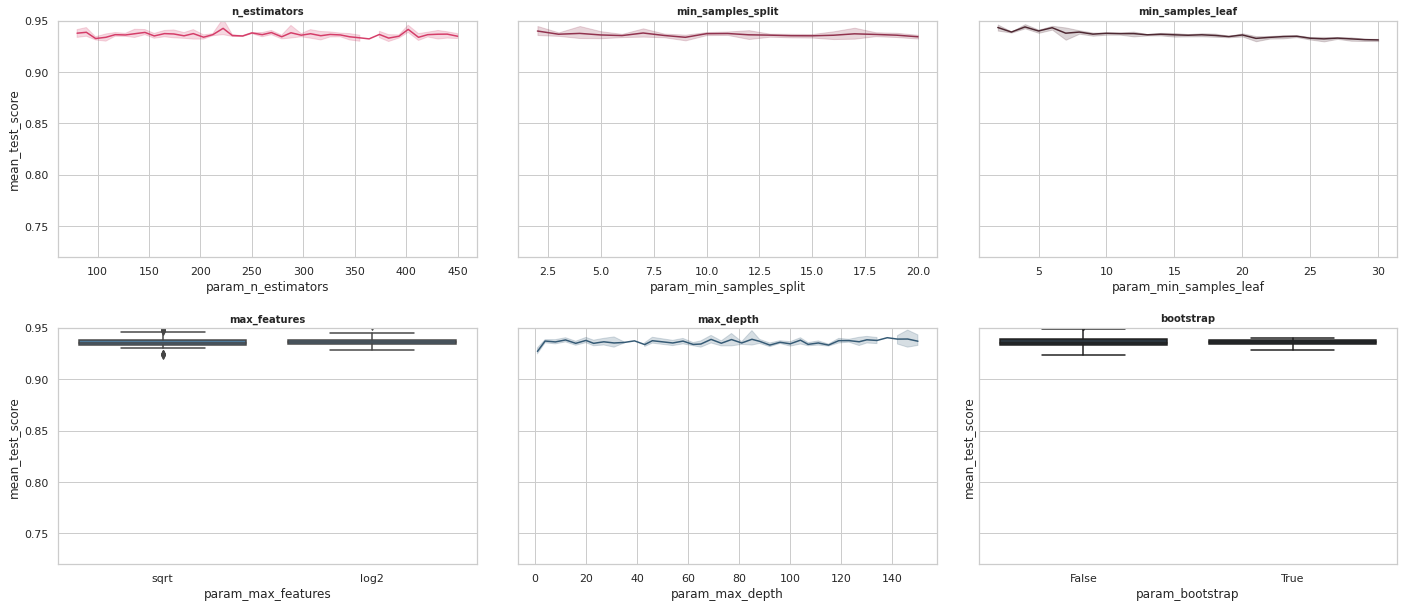

In [13]:
sns.set(style="whitegrid", color_codes=True, font_scale = 1)
fig, axs = plt.subplots(ncols=3, nrows=2  , sharey=True)
fig.set_size_inches(24,10)
colors = sns.diverging_palette(240, 0, n=6 , center='dark')
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0],color=colors[5]) 
axs[0,0].set_ylim([.72,.95])
axs[0,0].set_title(label = 'n_estimators', size=10, weight='bold')
sns.lineplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1],color=colors[4])
#axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'min_samples_split', size=10, weight='bold')
sns.lineplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2],color=colors[3])
#axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=10, weight='bold')
sns.boxplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0],color=colors[0])
#axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'max_features', size=10, weight='bold')
sns.lineplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1],color=colors[1])
#axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'max_depth', size=10, weight='bold')
sns.boxplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2] , color=colors[2])
#axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=10, weight='bold')
fig.subplots_adjust(wspace=0.1 , hspace=0.3)

plt.show()


### Result
> Best Model Parameters
```

{'n_estimators': 288,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 150,
 'bootstrap': False}
```
> Best Parameter values

```
{'n_estimators': [136 , 309 , 347,385],
 'min_samples_split': [7,12,44],
 'min_samples_leaf': [2,7,12],
 'max_features': 'sqrt',
 'max_depth': [43 ,85, 100],
 'bootstrap': False}
```

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
n_estimators = [140 , 170 , 230]
max_features = ['sqrt'] 
bootstrap = [False]
max_depth =  [56 ,85, 100]
min_samples_leaf = [2,12]
min_samples_split = [7,18,28]

In [ ]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [ ]:
gs = GridSearchCV(rfc_v2 , param_grid , cv=5 , verbose=5 , n_jobs=-1)
gs.fit(data_val , data_label)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [56, 85, 100],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2, 12],
                         'min_samples_split': [7, 18, 28],
                         'n_estimators': [140, 170, 230]},
             verbose=5)

In [ ]:
gs.best_params_

{'bootstrap': False,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 18,
 'n_estimators': 140}

# Best Random Forest

So Now we have identified best random Forest , lets see how its various performance are.

## Load Data

In [24]:
data_all =  pd.read_csv('../processed_data/train_none_rf_impute_cv_xrb' , index_col = 'obs_id').iloc[: , 1:]
display(data_all)


,class,src_n,src_id,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,...,bb_ampl_lolim,bb_ampl_hilim,bb_stat,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
obs_id,,,,,,,,,,,,,,,,,,,,,
BH_OBS_75,XRB,CXOU J100515.4-07425,BH0019,17.39,-15.279675,-15.264481,-15.545460,-15.108797,-14.892112,-15.772628,...,0.000000,0.000000,1.000,6.000,7.000,4.000,131.000000,164.0000,110.000,1.000
NS_OBS_179,XRB,XMMU J004245.2+41172,NS0044,49.26,-13.728158,-13.291664,-14.518128,-14.014394,-13.596365,-14.154158,...,0.000000,0.000000,1.000,6.000,7.000,4.000,134.000000,167.0000,111.000,1.000
CV_OBS_344,CV,2XMM J190109.3-220003,CV0061,31.89,-12.230918,-12.390619,-12.417596,-12.193142,-11.809388,-12.268250,...,0.003964,0.016860,3.726,2.069,2.177,1.966,0.000004,0.3872,22.000,1.070
CV_OBS_71,CV,[HPH2013] 123,CV0006,23.44,-14.738024,-13.599289,-14.746420,-13.856673,-13.899629,-14.000000,...,0.000000,0.000000,2.000,9.000,15.000,4.000,17.000000,25.0000,15.000,1.000
CV_OBS_731,CV,XMMSL2 J004231.9+41162,CV0110,174.76,-12.844968,-12.562567,-12.869345,-12.250341,-12.101110,-12.959398,...,0.000152,0.000333,3.899,14.120,21.980,8.500,0.000001,2.7220,16.000,0.719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CV_OBS_514,CV,CXOGLB J002406.0-72045,CV0081,25.99,-14.139004,-14.369572,-14.152304,-13.744969,-13.530473,-14.223735,...,0.000037,0.000065,2.500,3.500,5.026,2.507,6.513000,10.9200,2.512,1.093
NS_OBS_369,XRB,SAXWFC J1744.9-2921.,NS0068,9.04,-14.000000,-13.000000,-14.000000,-13.333388,-13.000000,-14.000000,...,0.000000,0.000000,1.000,8.000,7.000,4.000,126.000000,161.0000,105.000,1.000
CV_OBS_709,CV,XMMSL2 J004231.9+41162,CV0110,174.76,-12.864549,-13.654038,-12.718058,-12.249183,-12.074275,-13.000000,...,0.000264,0.000443,2.432,4.400,6.221,3.250,17.640000,26.8700,9.623,1.308


In [25]:
np.random.seed(433)
data = data_all.sample(frac=1)
data_label = data['class']
x = data.copy()
brems_model = ['brems_nh' , 'brems_nh_lolim' , 'brems_nh_hilim' , 'brems_kt' , 'brems_kt_lolim' , 'brems_kt_hilim']
inter_obs_param = ['var_inter_index' , 'var_inter_prob' , 'var_inter_sigma' , 'bb_kt_hilim']
x = x.drop(columns = brems_model + inter_obs_param +['bb_stat'])
y = data_label.copy()
x

,class,src_n,src_id,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,...,powlaw_stat,bb_kt,bb_kt_lolim,bb_nh_hilim,bb_nh_lolim,bb_nh,bb_ampl,bb_ampl_lolim,bb_ampl_hilim,brems_stat
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_OBS_259,CV,[HPH2013] 273,CV0035,9.19,-13.792904,-13.861066,-13.921543,-13.309450,-13.191654,-14.262410,...,1.000,0.0000,0.0000,5.0000,22.0,2.000000e+00,0.000000,0.00000,0.000000,1.000
NS_OBS_420,XRB,1WGA J0748.5-6745,NS0076,6.77,-15.152551,-14.000000,-15.368252,-14.138585,-14.147520,-15.763463,...,1.000,0.0000,0.0000,54.0000,45.0,3.900000e+01,0.000000,0.00000,0.000000,1.000
CV_OBS_716,CV,XMMSL2 J004231.9+41162,CV0110,174.76,-12.879755,-13.358923,-12.835350,-12.185553,-12.045275,-12.931814,...,1.000,0.7657,0.7440,0.2454,22.0,1.856000e-07,0.000185,0.00018,0.000203,0.988
BH_OBS_187,XRB,KV UMA,BH0028,12.97,-14.207748,-13.855426,-14.398157,-14.192533,-13.811634,-14.328549,...,1.000,0.0000,0.0000,97.0000,56.0,6.300000e+01,0.000000,0.00000,0.000000,1.000
CV_OBS_331,CV,2XMM J004414.4+412204,CV0054,6.53,-14.283162,-13.421475,-14.675923,-12.947691,-13.007314,-14.000000,...,1.000,0.0000,0.0000,102.0000,63.0,7.100000e+01,0.000000,0.00000,0.000000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CV_OBS_750,CV,XMMSL2 J004231.9+41162,CV0110,174.76,-12.801618,-13.345631,-12.832978,-12.300509,-12.120503,-12.934420,...,0.482,0.6736,0.6218,1.6890,22.0,1.324000e-06,0.000237,0.00022,0.000311,0.459
NS_OBS_93,XRB,EXO 1745-248,NS0020,23.47,-15.040577,-14.000000,-14.312114,-14.044793,-13.889747,-15.670602,...,1.000,0.0000,0.0000,102.0000,63.0,7.100000e+01,0.000000,0.00000,0.000000,1.000
CV_OBS_660,CV,CXOGLB J002415.8-72043,CV0093,21.99,-13.795066,-13.596879,-14.072322,-13.174120,-13.120560,-14.095988,...,1.000,0.0000,0.0000,5.0000,22.0,2.000000e+00,0.000000,0.00000,0.000000,1.000


## Train and save model

{'n_estimators': 222,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 85,
 'bootstrap': False}

In [26]:
# Find and fit besst model
train_acc = []
test_acc = []
best_clf = ''
score = 0 
for i in tqdm(range(1)):
    rs = int(np.random.uniform(10 , 99999))
    '''
    27601 0.958974358974359
    79324
    '''
    #rs = 60328 #with brems
    rs =  87023 #without brems works whether bb_stat included or not
    np.random.seed(rs)
    df =  x.sample(frac=1 , random_state=rs)
    y = df['class']
    x_train , x_test , _ , _ = train_test_split(df , y , test_size=0.2 , shuffle=True, random_state=10 , stratify=y)
    info_col = ['src_n' , 'src_id' , 'significance' , 'class']
    id_train = x_train[info_col]
    id_test = x_test[info_col]
    y_train = x_train['class']
    y_test = x_test['class']
    x_train = x_train.drop(info_col , axis=1)
    x_test = x_test.drop(info_col , axis = 1 )
    #np.random.seed(5926)
    clf = RandomForestClassifier(
        n_estimators= 222 , 
        criterion='entropy' ,
        random_state=12,
        max_depth=85 , 
        min_samples_leaf= 2 , 
        min_samples_split=2 , 
        bootstrap=False ,
        max_features='sqrt' ,
        class_weight='balanced'
        )
    clf.fit(x_train , y_train)
    tr = clf.score(x_train , y_train)
    next_score = clf.score(x_test , y_test)
    if(next_score > score):
        best_clf = clf
        score = next_score
        print('better found' , rs , next_score)
    #print(next_score , score)
    #print('\n -----------------')
    #print(rs , tst)
    ##train_acc.append(tr)
    #test_acc.append(tst)

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

better found 87023 0.9897435897435898


In [27]:
test_score =  best_clf.score(x_test , y_test)
print(test_score)

0.9897435897435898


### Entropy-Wise Feature Importance

In [28]:
feat_imp = clf.feature_importances_
feat_names = x_train.columns.to_list()
feat = pd.DataFrame()
feat.insert( 0 , 'feat_name' , feat_names)
feat.insert(1 , 'feat_imp' , feat_imp)
feat = feat.sort_values(by = 'feat_imp' , ascending=False).reset_index(drop=True)
feat_names_sorted = feat['feat_name']
display(feat)
#feat.to_csv('result/feat_imp.csv')

,feat_name,feat_imp
0,powlaw_nh,0.143730
1,powlaw_nh_hilim,0.119387
2,powlaw_nh_lolim,0.119087
3,bb_nh,0.103714
4,bb_nh_hilim,0.085447
...,...,...
76,flux_brems,0.001471
77,var_index,0.001431
78,flux_bb_lolim,0.001187
79,flux_powlaw_lolim,0.001161


## Bake Result

### Function

In [29]:
def create_res_data(x , y , id_data  , cl_type):
    pred = clf.predict(x)
    pred_prob = np.asarray(clf.predict_proba(x))
    pred_prob_xrb = pred_prob[:,0]
    pred_prob_cv = pred_prob[:,1]
    pred_prob = [np.amax(pi) for pi in pred_prob]
    res =  x.copy()
    res = res[feat_names_sorted]
    #id_data = id_data.reset_index(drop=True)
    res.insert(0 , 'clf_type' , [cl_type]*len(res))
    res.insert(1 , 'true_class' , y)
    res.insert(2 ,'pred_class' , pred)
    res.insert(3 , 'pred_prob' , pred_prob)
    res.insert(4 , 'XRB_prob' , pred_prob_xrb)
    res.insert(5 , 'CV_prob' , pred_prob_cv)
    res = pd.concat([id_data , res] , axis=1).drop('class' , axis=1)
    truth = []
    th_class = [] 
    is_ok = [] 
    for tc , pc , pp in zip(res['true_class'] , res['pred_class'] , res['pred_prob']):
        if(tc==pc): is_ok.append(1)
        else: is_ok.append(0)
        if(pp > 0.80):
            th_class.append(pc)
            if(tc==pc):
                truth.append(1)
            else: truth.append(0)
        else :
            truth.append(2)
            th_class.append('X')
    res.insert(5 , 'th_class' , th_class )
    res.insert(6 , 'truth' , truth)
    res.insert(6 , 'is_ok' , is_ok)
    return res


### Bake it

In [30]:

train_res = create_res_data(x_train , y_train ,id_train , cl_type='train')
test_res = create_res_data(x_test , y_test ,id_test , cl_type='test')
#train_res.to_csv('result/train_res_rf.csv')
#test_res.to_csv('result/test_res_rf.csv')
res_data = pd.concat([train_res , test_res])
#res_data =  res_data.set_index('obs_id')
#res_data.to_csv('../result/res_rf_tuned_rf_impute.csv')
res_data

,src_n,src_id,significance,clf_type,true_class,th_class,is_ok,truth,pred_class,pred_prob,...,kp_prob,bb_ampl_hilim,flux_brems_lolim,flux_powlaw_hilim,flux_powlaw,flux_brems,var_index,flux_bb_lolim,flux_powlaw_lolim,flux_bb
obs_id,,,,,,,,,,,,,,,,,,,,,
NS_OBS_318,XMMU J004414.0+41220,NS0047,6.53,train,XRB,X,1,2,XRB,0.500289,...,0.00000,0.000000,-12.000000,-12.000000,-12.000000,-12.000000,0.0,-12.000000,-12.000000,-12.000000
NS_OBS_123,GRS 1741.9-2853,NS0021,376.06,train,XRB,XRB,1,1,XRB,0.995093,...,0.00000,0.000000,-12.000000,-12.000000,-12.000000,-12.000000,0.0,-12.000000,-12.000000,-12.000000
CV_OBS_129,[HPH2013] 143,CV0011,10.38,train,CV,CV,1,1,CV,0.969888,...,1.00000,0.000000,-12.000000,-12.000000,-12.000000,-12.000000,7.0,-12.000000,-12.000000,-12.000000
CV_OBS_304,[HPH2013] 50,CV0037,9.94,train,CV,CV,1,1,CV,0.995270,...,0.00000,0.000000,-12.000000,-12.000000,-12.000000,-12.000000,0.0,-12.000000,-12.000000,-12.000000
NS_OBS_197,XMMU J004245.2+41172,NS0044,49.26,train,XRB,XRB,1,1,XRB,0.941851,...,0.70675,0.000064,-13.203356,-13.066108,-13.113453,-13.119358,1.0,-13.378720,-13.160585,-13.281083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CV_OBS_668,CXOGLB J002416.9-72042,CV0094,38.28,test,CV,CV,1,1,CV,0.990002,...,0.74500,0.000000,-12.000000,-12.000000,-12.000000,-12.000000,1.0,-12.000000,-12.000000,-12.000000
CV_OBS_769,XMMSL2 J004231.9+41162,CV0110,174.76,test,CV,CV,1,1,CV,1.000000,...,0.37875,0.000306,-12.263126,-12.155274,-12.191519,-12.203148,0.0,-12.294650,-12.228486,-12.252355
BH_OBS_161,J1745-2900,BH0027,337.00,test,XRB,XRB,1,1,XRB,1.000000,...,0.00000,0.000000,-12.000000,-12.000000,-12.000000,-12.000000,0.0,-12.000000,-12.000000,-12.000000


# Result Analysis

In [31]:
cv_data = res_data[res_data['true_class']=='CV']
cv_sources = np.unique(cv_data['src_id'])
print('Num of CV sources :' , len(cv_sources))
print('Num of CV obs :' , len(cv_data))

cv_data = res_data[res_data['true_class']=='XRB']
cv_sources = np.unique(cv_data['src_id'])
print('Num of LMXRB sources :' , len(cv_sources))
print('Num of LMXRB obs :' , len(cv_data))

Num of CV sources : 65
Num of CV obs : 515
Num of LMXRB sources : 75
Num of LMXRB obs : 460


In [32]:
data =  res_data.copy()
total = len(data)
print('Total samples' , total)
am_clf = len(data[data['th_class']=='X'])
print('Ambiguous calssification : ' , am_clf)
wrong_clf = len(data[data['truth']==0])
print('Wrong calssification : ' , wrong_clf)

acc = (total-am_clf-wrong_clf)/total
print('Classification accuracy :{:.3f}'.format(acc))

Total samples 975
Ambiguous calssification :  26
Wrong calssification :  2
Classification accuracy :0.971


## ROC Curve

In [34]:
from sklearn.metrics import roc_curve , det_curve , roc_auc_score

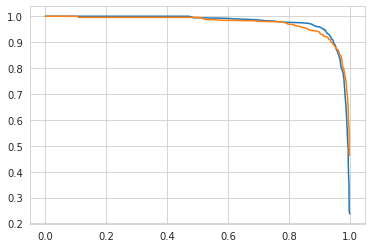

In [35]:
fpr , fnr , threshold = det_curve(res_data['true_class'] , res_data['XRB_prob'] , pos_label='XRB')
plt.plot(threshold , fpr)
fpr , fnr , threshold = det_curve(res_data['true_class'] , res_data['CV_prob'] , pos_label='CV')
plt.plot(threshold , fpr)
plt.show()

In [37]:
roc_auc = roc_auc_score(res_data['true_class'] , res_data['CV_prob'])
roc_auc

0.9997783875052765

## Feature Importance

multiplying the average standardised mean value of each feature split on each class, with the corresponding model._feature_importances array element. You can write a simple function that standardises your dataset, computes the mean of each feature split across class predictions, and does element-wise multiplication with the model._feature_importances array. The greater the absolute resulting values are, the more important the features will be to their predicted class, and better yet, the sign will tell you if it is small or large values that are important.

https://stackoverflow.com/questions/35249760/using-scikit-to-determine-contributions-of-each-feature-to-a-specific-class-pred/35255612

In [38]:
from sklearn.preprocessing import scale
import json
def class_feature_importance(X, Y, feature_importances):
    N, M = X.shape
    X = scale(X)

    out = {}
    for c in set(Y):
        print(c)
        out[c] = dict(
            zip(range(M), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )
    return out


In [39]:
feat_imp = best_clf.feature_importances_ 
result = class_feature_importance(x_train , y_train , feat_imp)
#print(json.dumps(result,indent=4))

CV
XRB


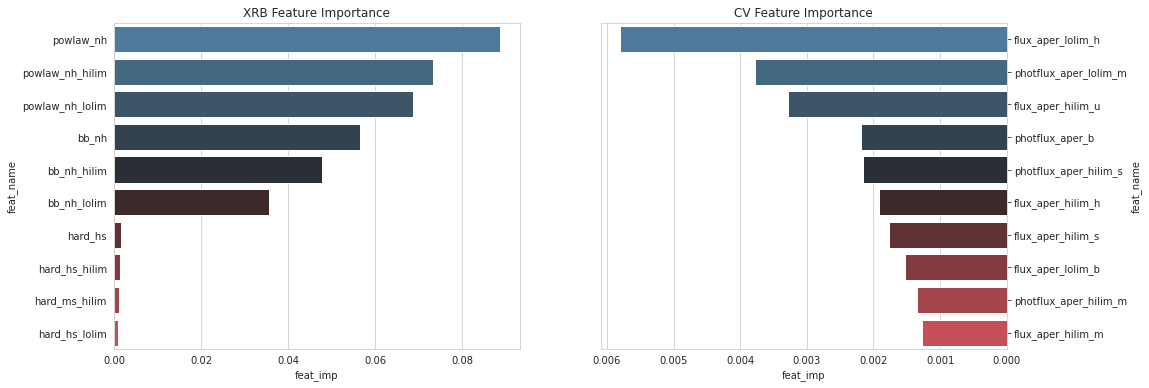

In [40]:
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols=2 , figsize=(16,6))
feat_names = x_train.columns.to_list()
top_feat = 10
#result['BH'].keys() = feat_names
values = list(result['XRB'].values())
df=  pd.DataFrame()
df.insert(0 , 'feat_name' , feat_names)
df.insert(1 , 'feat_imp' , values)
df = df.sort_values(by='feat_imp' , ascending=False)
df_feat_cla = df.copy() # cla - class A
palette = sns.diverging_palette(240, 10, n=top_feat , center='dark')
ax1 = sns.barplot(data = df.iloc[:top_feat,:] ,y = 'feat_name' , x = 'feat_imp'  ,palette = palette, ax=ax[0] )

values = list(result['CV'].values())
df=  pd.DataFrame()
df.insert(0 , 'feat_name' , feat_names)
df.insert(1 , 'feat_imp' , values)
df = df.sort_values(by='feat_imp' , ascending=False)
df_feat_clb = df.copy() # clb - class B
palette = sns.diverging_palette(240, 10, n=top_feat , center='dark')
ax2 = sns.barplot(data = df.iloc[:top_feat,:] ,y = 'feat_name' , x = 'feat_imp'  ,palette = palette, ax=ax[1] )
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.invert_xaxis()
ax1.set_title('XRB Feature Importance')
ax2.set_title('CV Feature Importance')
plt.show()

In [41]:
def is_outlier(points, thresh):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = np.asarray(points)
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation    
    return modified_z_score > thresh

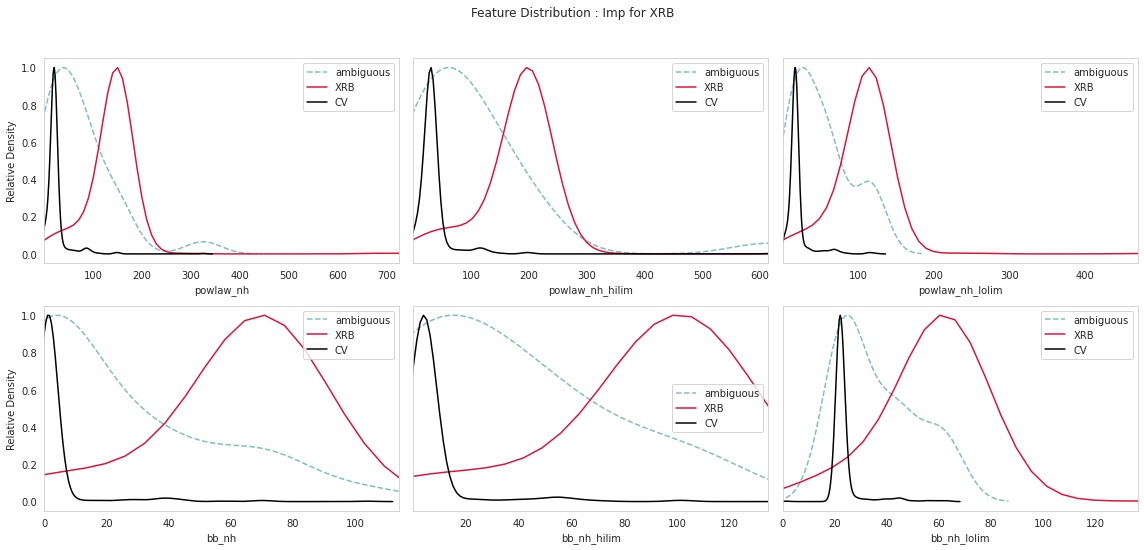

In [42]:
fig, axs = plt.subplots(2,3, sharey=True, sharex=False , figsize=(16 , 8))
col = sns.diverging_palette(240, 10, n=6 , center='dark')
f_name  =  df_feat_cla['feat_name'][:6]
axs = np.ndarray.flatten(axs)
sns.set_style('white')
i = 0 
for f , axi in zip(f_name , axs):
    if(f=='bb_nh_lolim'):
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=150)]
    elif(f=='bb_nh'):
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=100)]
    else:
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=20)]
    #filtered_res = res_data.copy()
    #print(f)
    ax = sns.displot(data = res_data , x = f ,hue = 'true_class' , kind='kde' ,)
    plt.close()
    ax2 = sns.displot(data = res_data[res_data['th_class']=='X'] , x = f ,hue = 'th_class' , kind='kde' ,)
    plt.close()
    amb  , amb_x= ax2.ax.lines[0].get_ydata() , ax2.ax.lines[0].get_xdata()
    amb =  amb / np.amax(amb)
    bh  ,  bh_x = ax.ax.lines[0].get_ydata() , ax.ax.lines[0].get_xdata() 
    bh = bh /np.amax(bh) 
    ns , ns_x = ax.ax.lines[1].get_ydata() , ax.ax.lines[1].get_xdata()
    ns = ns/np.amax(ns)
    #x_val = ax.ax.lines[0].get_xdata() , ax.ax.lines[1].get_xdata()
    #plt.close()
    axi.plot(amb_x , amb , label = 'ambiguous' , color='teal' , alpha=0.5 , linestyle='--')
    axi.plot(ns_x , ns , label = 'XRB' , color='crimson')
    axi.plot(bh_x , bh , label = 'CV' , color = 'black')
    axi.legend()
    axi.set_xlim(np.amin(filtered_res[f]) , np.amax(filtered_res[f]))
    axi.grid(True , color='k' , linestyle=':' , alpha=0.4)
    axi.grid(False)
    axi.set_xlabel(f)
    #axi.set_xscale('log')
    if(not(i%3)):
        axi.set_ylabel('Relative Density')
    i+=1    
    #axi.text(0.1 , 0.1 ,  'Feature : '+f)
fig.suptitle('Feature Distribution : Imp for XRB')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.close()


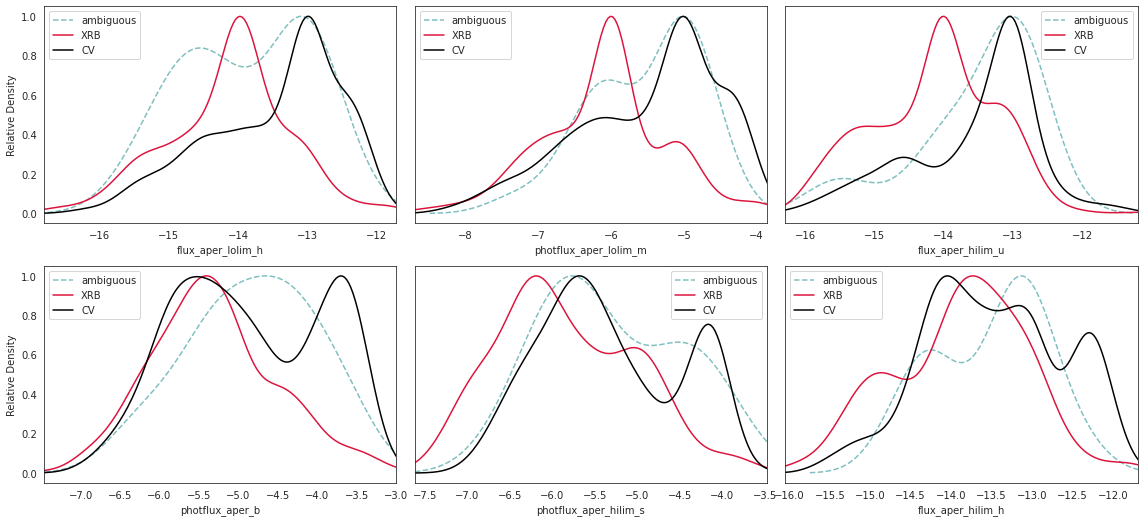

In [43]:
fig, axs = plt.subplots(2,3, sharey=True, sharex=False , figsize=(16 , 8))
col = sns.diverging_palette(240, 10, n=6 , center='dark')
f_name  =  df_feat_clb['feat_name'][:6]
axs = np.ndarray.flatten(axs)
sns.set_style('white')
i = 0 
for f , axi in zip(f_name , axs):
    if(f=='bb_stat'):
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=650)]
    else:
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=350)]
    #filtered_res = res_data.copy()
    #print(f)
    ax = sns.displot(data = res_data , x = f ,hue = 'true_class' , kind='kde' ,)
    plt.close()
    ax2 = sns.displot(data = res_data[res_data['th_class']=='X'] , x = f ,hue = 'th_class' , kind='kde' ,)
    plt.close()
    amb  , amb_x= ax2.ax.lines[0].get_ydata() , ax2.ax.lines[0].get_xdata()
    amb =  amb / np.amax(amb)
    bh  ,  bh_x = ax.ax.lines[0].get_ydata() , ax.ax.lines[0].get_xdata() 
    bh = bh /np.amax(bh) 
    ns , ns_x = ax.ax.lines[1].get_ydata() , ax.ax.lines[1].get_xdata()
    ns = ns/np.amax(ns)
    #x_val = ax.ax.lines[0].get_xdata() , ax.ax.lines[1].get_xdata()
    #plt.close()
    axi.plot(amb_x , amb , label = 'ambiguous' , color='teal' , alpha=0.5 , linestyle='--')
    axi.plot(ns_x , ns , label = 'XRB' , color='crimson')
    axi.plot(bh_x , bh , label = 'CV' , color = 'black')
    axi.legend()
    axi.set_xlim(np.amin(filtered_res[f]) , np.amax(filtered_res[f]))
    axi.grid(True , color='k' , linestyle=':' , alpha=0.4)
    axi.grid(False)
    axi.set_xlabel(f)
    #axi.set_xscale('log')
    if(not(i%3)):
        axi.set_ylabel('Relative Density')
    i+=1    
    #axi.text(0.1 , 0.1 ,  'Feature : '+f)
#fig.suptitle('Feature Distribution')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.close()
